In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
from PIL import Image, ImagePath, ImageDraw
import os
import pathlib
import re
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
colab_path = "/content/drive/MyDrive/"
content_folder = "/content/"

In [59]:
test = pd.read_csv(colab_path + "icdar_cropped_images/test_cropped_data")
test['images'] = test['images'].apply(lambda x: "icdar_" + x)
test = test[test['text'].notnull()]
test.head()

,images,text
8,icdar_cropped_images/test/image_8.jpg,Please
9,icdar_cropped_images/test/image_9.jpg,lower
10,icdar_cropped_images/test/image_10.jpg,your
11,icdar_cropped_images/test/image_11.jpg,volume
12,icdar_cropped_images/test/image_12.jpg,when


In [60]:
#Preparing vocabulary for Text Recognition Branch
#https://github.com/qjadud1994/CRNN-Keras/blob/master/Model_GRU.py
TOTAL_CHARS = " 0123456789abcdefghijklmnopqrstuvwxyzéABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(TOTAL_CHARS) 
char_index={}
index_char={}
for i,val in enumerate(TOTAL_CHARS):
  index_char[i+1]=val
  char_index[val]=i+1

In [61]:
#https://github.com/qjadud1994/CRNN-Keras/blob/master/Model_GRU.py
class ctc_loss(tf.keras.losses.Loss):
  def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Loss_layer'):
      super(ctc_loss, self).__init__(reduction=reduction, name=name)
  def call(self, y_true, y_pred):
    
    #Getting geo_map and score_maps
    label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((128,1),'int32')*64,label_length)

In [62]:
# model = load_model('/content/Text_Recognition_syntext.h5', custom_objects={'ctc_loss': ctc_loss()})
model = load_model('/content/text_recognition_best.h5', custom_objects={'ctc_loss': ctc_loss()})

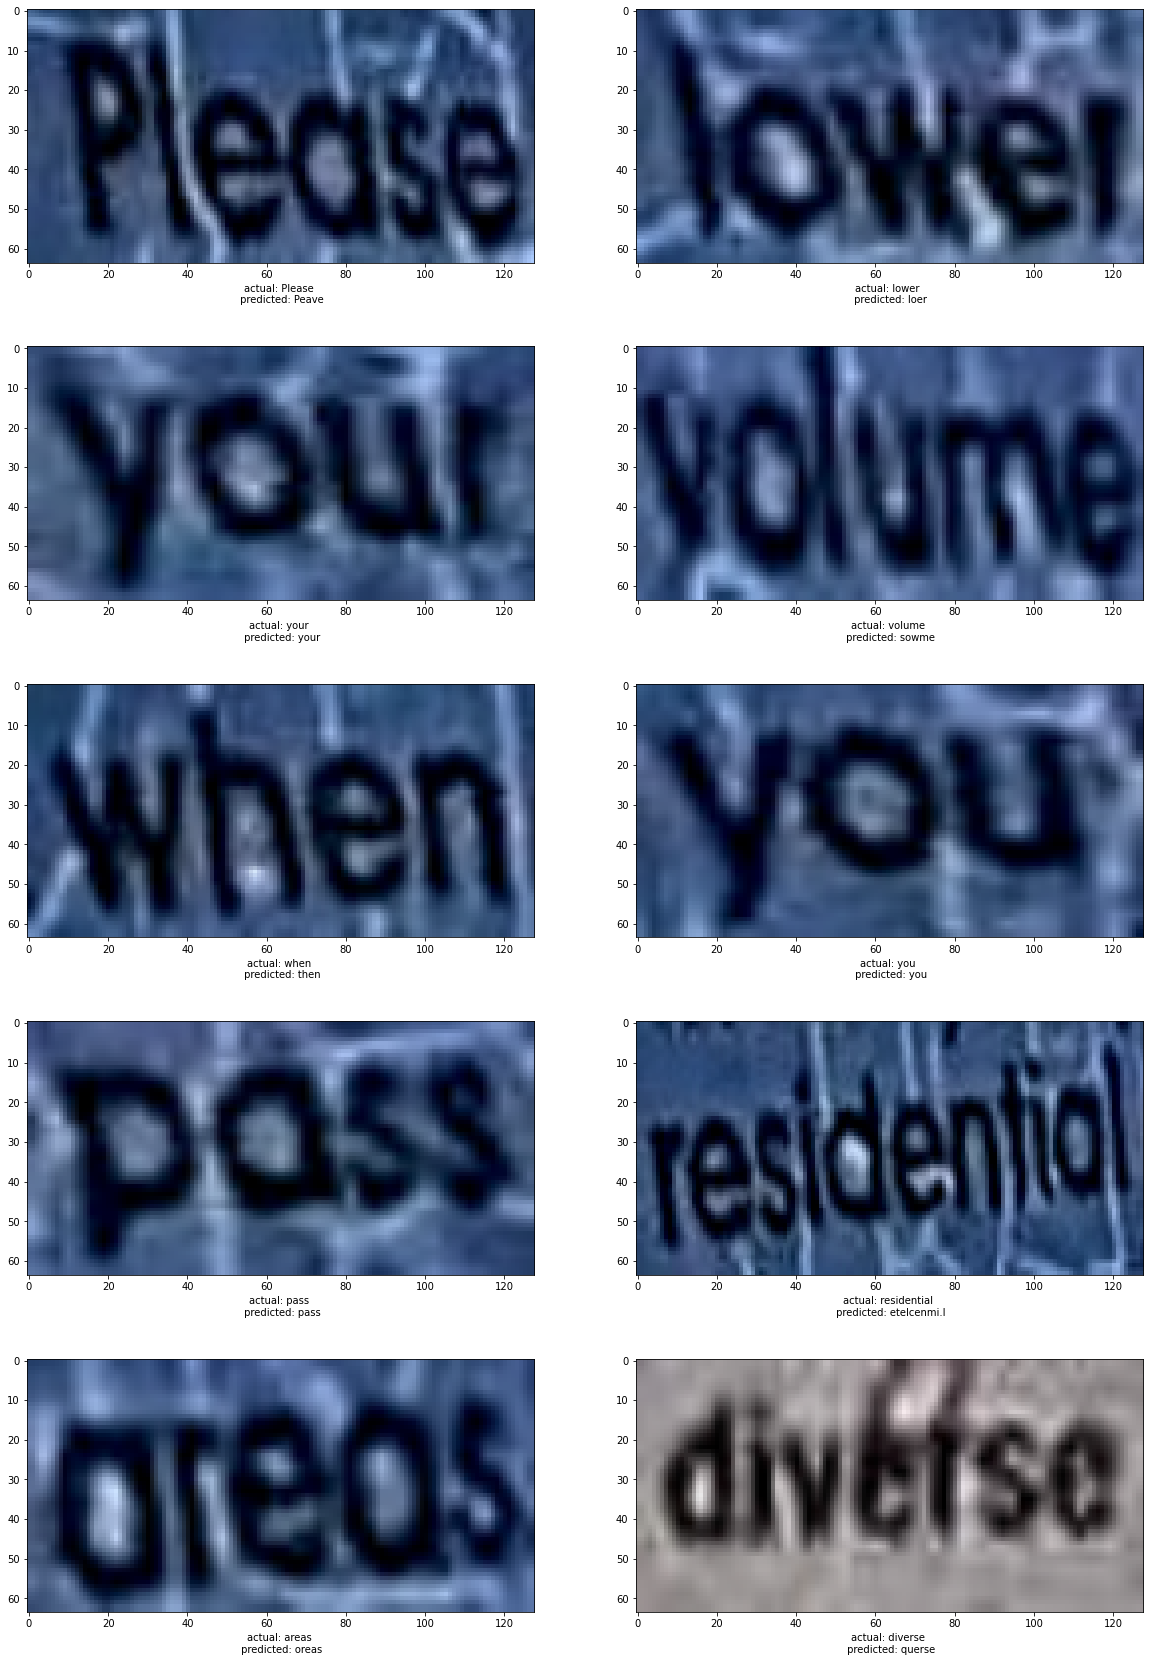

In [48]:
plt.figure(figsize= (20,30))
count = 1
starts, ends = 0, 10 

for img_no in range(starts, ends):
  plt.subplot(5, 2, count)
  img = cv2.imread(colab_path + test.iloc[img_no]['images']) #reading img from path
  img = cv2.detailEnhance(img) #pre processing img
  img = cv2.resize(img, (128,64),cv2.INTER_NEAREST) #resizing
  img_for_plot = img
  img = np.expand_dims(img, axis = 0) #expanding dims to accomodate batch size
  prediction = model.predict(img) #predicting, shape after prediction = (1, 64, 100)
  # print("original_text: ", test.iloc[img_no]['text']) #original

  # use CTC decoder
  #https://github.com/TheAILearner/A-CRNN-model-for-Text-Recognition-in-Keras/blob/master/CRNN%20Model.ipynb
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                          greedy=True)[0][0])
  final_word = []
  for i in out[0]:
    if i != -1:
      final_word.append(index_char[i])
  plt.imshow(img_for_plot)
  plt.xlabel("actual: {} \n predicted: {}".format(test.iloc[img_no]['text'], "".join(final_word)))
  count += 1
  # print("predicted_word: ", "".join(final_word),"\n")